<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/ELM/ELM_(Traditional)_vs_PSO_ELM_(Binary_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# ============================================
# ELM (Traditional) vs PSO-ELM (Binary Classification)
# Minimal, simple, and self-contained
# ============================================

import os
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, log_loss, accuracy_score, f1_score

# -------------------------------
# Hyperparameters (EDIT HERE)
# -------------------------------
RANDOM_STATE   = 42

# ELM hidden layer
N_HIDDEN       = 20            # number of hidden neurons
ACTIVATION     = "relu"         # relu | tanh | sigmoid | linear
RIDGE_ALPHA    = 1e-2           # ridge regularization for beta

# PSO parameters (for ELM hidden weights+biases)
PSO_SWARM_SIZE = 30
PSO_ITERS      = 60
PSO_W          = 0.7            # inertia
PSO_C1         = 1.5            # cognitive
PSO_C2         = 1.5            # social
PSO_INIT_SCALE = 0.5            # initialization range: U(-scale, scale)
PSO_VCLIP      = 0.5            # velocity clip per-dimension
PSO_RUNS       = 10             # number of independent PSO runs (for average curve)

# -------------------------------
# Data (CSV; last column = class)
# -------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

CSV_PATH = "diabetes.csv"  # change if needed

df = pd.read_csv(CSV_PATH)

# X = all columns except last, y = last column
X_all = df.iloc[:, :-1].to_numpy(dtype=float)
y_raw = df.iloc[:, -1]

# If labels aren't numeric, factorize them to 0..K-1
if np.issubdtype(y_raw.dtype, np.number):
    y_all = y_raw.to_numpy(dtype=int)
else:
    y_all = pd.factorize(y_raw)[0].astype(int)

# Train/Test split (stratified)
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.25, random_state=RANDOM_STATE, stratify=y_all
)

# Optional: scale features
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

n_features = X_tr.shape[1]

# Ensure fig dir
os.makedirs("figs", exist_ok=True)

# -------------------------------
# ELM utilities
# -------------------------------
def act_fn(z: np.ndarray, name: str) -> np.ndarray:
    name = name.lower()
    if name == "relu":
        return np.maximum(0.0, z)
    if name == "tanh":
        return np.tanh(z)
    if name == "sigmoid":
        return 1.0 / (1.0 + np.exp(-z))
    if name == "linear":
        return z
    raise ValueError(f"Unsupported activation: {name}")

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -30, 30)))

def proba_from_logits(z):
    p1 = sigmoid(z.ravel())
    return np.stack([1.0 - p1, p1], axis=1)  # (N,2)

def elm_unpack_hidden(theta: np.ndarray, n_features: int, n_hidden: int) -> Tuple[np.ndarray, np.ndarray]:
    W = theta[: n_features * n_hidden].reshape(n_features, n_hidden)
    b = theta[n_features * n_hidden : n_features * n_hidden + n_hidden]
    return W, b

def fit_beta_ridge(H: np.ndarray, Y: np.ndarray, alpha: float) -> np.ndarray:
    M = H.shape[1]
    return np.linalg.solve(H.T @ H + alpha * np.eye(M), H.T @ Y)

def elm_forward_logits(X: np.ndarray, W: np.ndarray, b: np.ndarray, activation: str, beta: np.ndarray) -> np.ndarray:
    H = act_fn(X @ W + b, activation)
    return H @ beta  # (N,1)

# -------------------------------
# Traditional ELM (random hidden W,b)
# -------------------------------
def train_traditional_elm(X, y, activation, n_hidden, alpha, seed=RANDOM_STATE):
    r = np.random.default_rng(seed)
    W = r.normal(0, 1, size=(X.shape[1], n_hidden))
    b = r.normal(0, 1, size=(n_hidden,))
    H = act_fn(X @ W + b, activation)
    Y = y.astype(float).reshape(-1, 1)
    beta = fit_beta_ridge(H, Y, alpha)
    return W, b, beta

# -------------------------------
# PSO (optimize hidden W,b; beta solved each eval on TRAIN)
# -------------------------------
ELM_DIM = n_features * N_HIDDEN + N_HIDDEN

def elm_train_loss_from_theta(theta: np.ndarray) -> float:
    W, b = elm_unpack_hidden(theta, n_features, N_HIDDEN)
    H_tr = act_fn(X_tr @ W + b, ACTIVATION)
    beta = fit_beta_ridge(H_tr, y_tr.reshape(-1,1).astype(float), RIDGE_ALPHA)
    proba = proba_from_logits(H_tr @ beta)
    return float(log_loss(y_tr, proba))

def pso_optimize(loss_fn, dim, rng_seed, iters=PSO_ITERS, swarm=PSO_SWARM_SIZE,
                 w=PSO_W, c1=PSO_C1, c2=PSO_C2, init_scale=PSO_INIT_SCALE, vclip=PSO_VCLIP):
    r = np.random.default_rng(rng_seed)
    Xp = r.uniform(-init_scale, init_scale, size=(swarm, dim))  # positions
    V  = r.uniform(-init_scale, init_scale, size=(swarm, dim))  # velocities

    pbest_pos = Xp.copy()
    pbest_val = np.array([loss_fn(p) for p in Xp])
    gbest_idx = int(np.argmin(pbest_val))
    gbest_pos = pbest_pos[gbest_idx].copy()
    gbest_val = float(pbest_val[gbest_idx])

    best_curve = [gbest_val]
    for t in range(iters):
        for i in range(swarm):
            r1 = r.random(dim); r2 = r.random(dim)
            V[i] = w*V[i] + c1*r1*(pbest_pos[i] - Xp[i]) + c2*r2*(gbest_pos - Xp[i])
            V[i] = np.clip(V[i], -vclip, vclip)
            Xp[i] = Xp[i] + V[i]

            val = loss_fn(Xp[i])
            if val < pbest_val[i]:
                pbest_val[i] = val
                pbest_pos[i] = Xp[i].copy()
                if val < gbest_val:
                    gbest_val = float(val)
                    gbest_pos = Xp[i].copy()
        best_curve.append(gbest_val)
    return gbest_pos, gbest_val, np.array(best_curve)

# Run PSO multiple times — keep best theta & compute average curve
all_curves = []
best_overall_val = np.inf
best_overall_theta = None

for run in range(PSO_RUNS):
    seed = RANDOM_STATE + 97*run
    theta, val, curve = pso_optimize(elm_train_loss_from_theta, ELM_DIM, seed)
    all_curves.append(curve)
    if val < best_overall_val:
        best_overall_val = val
        best_overall_theta = theta.copy()

all_curves = np.stack(all_curves, axis=0)  # (runs, iters+1)
avg_curve  = all_curves.mean(axis=0)
best_curve = all_curves[np.argmin(all_curves[:, -1])]

# -------------------------------
# Train Traditional + Build PSO-ELM (beta on train with best theta)
# -------------------------------
W_trad, b_trad, beta_trad = train_traditional_elm(X_tr, y_tr, ACTIVATION, N_HIDDEN, RIDGE_ALPHA, seed=RANDOM_STATE)

W_pso, b_pso = elm_unpack_hidden(best_overall_theta, n_features, N_HIDDEN)
H_tr_pso     = act_fn(X_tr @ W_pso + b_pso, ACTIVATION)
beta_pso     = fit_beta_ridge(H_tr_pso, y_tr.reshape(-1,1).astype(float), RIDGE_ALPHA)

# Predictions — TRAIN
proba_trad_tr = proba_from_logits(elm_forward_logits(X_tr, W_trad, b_trad, ACTIVATION, beta_trad))
proba_pso_tr  = proba_from_logits(elm_forward_logits(X_tr, W_pso,   b_pso,   ACTIVATION, beta_pso))
yhat_trad_tr  = np.argmax(proba_trad_tr, axis=1)
yhat_pso_tr   = np.argmax(proba_pso_tr,  axis=1)

# Predictions — TEST
proba_trad_te = proba_from_logits(elm_forward_logits(X_te, W_trad, b_trad, ACTIVATION, beta_trad))
proba_pso_te  = proba_from_logits(elm_forward_logits(X_te, W_pso,   b_pso,   ACTIVATION, beta_pso))
yhat_trad_te  = np.argmax(proba_trad_te, axis=1)
yhat_pso_te   = np.argmax(proba_pso_te,  axis=1)


In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, log_loss

def metrics_row(name, y_true, y_pred, proba):
    return {
        "run": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "log_loss": log_loss(y_true, proba)
    }

rows = [
    metrics_row("Trad-TR", y_tr, yhat_trad_tr, proba_trad_tr),
    metrics_row("Trad-TE", y_te, yhat_trad_te, proba_trad_te),
    metrics_row("PSO-TR",  y_tr, yhat_pso_tr,  proba_pso_tr),
    metrics_row("PSO-TE",  y_te, yhat_pso_te,  proba_pso_te),
]

metrics_df = pd.DataFrame(rows)[["run", "accuracy", "f1", "log_loss"]]

# Save & view
import os
os.makedirs("figs", exist_ok=True)
metrics_df.to_csv("figs/elm_metrics_summary.csv", index=False)

print(metrics_df.to_string(index=False))
print("Saved -> figs/elm_metrics_summary.csv")


    run  accuracy       f1  log_loss
Trad-TR  0.406250 0.540323  0.695460
Trad-TE  0.401042 0.538153  0.711862
 PSO-TR  0.618056 0.638158  0.649059
 PSO-TE  0.572917 0.585859  0.682096
Saved -> figs/elm_metrics_summary.csv


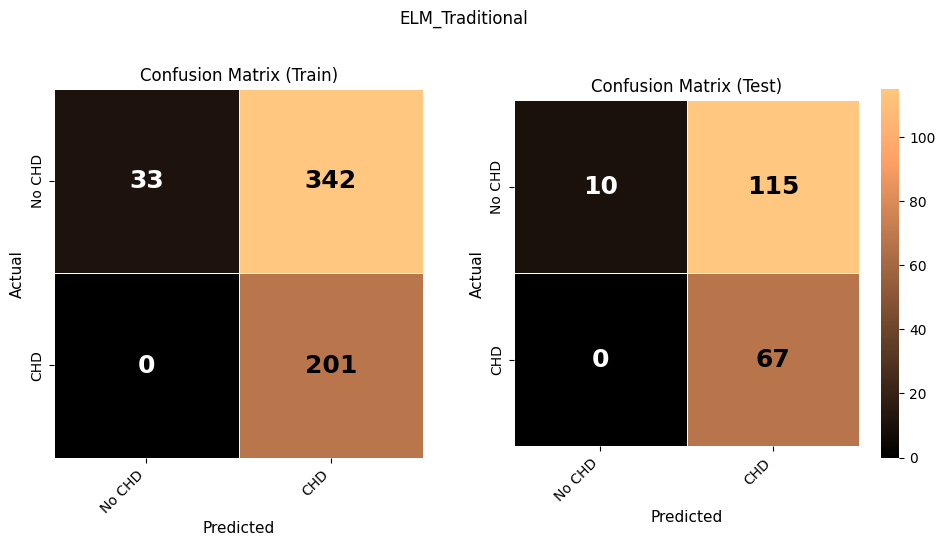

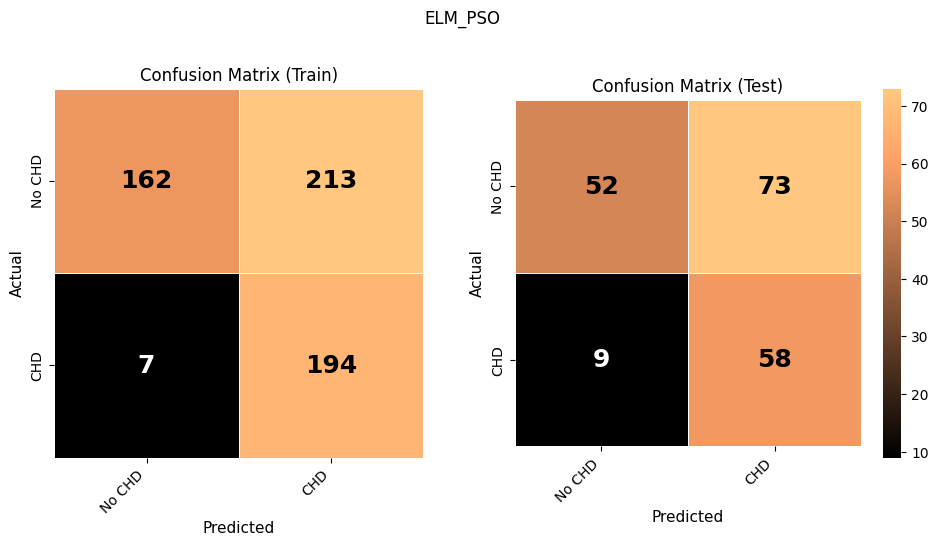

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -------------------------------
# Confusion Matrices (brown/copper heatmap, big text, auto white on dark)
# -------------------------------
def plot_confusions(y_train, y_train_pred, y_test, y_test_pred, model_name="Model", class_names=None):
    """
    Draw TRAIN and TEST confusion matrices side-by-side using seaborn.heatmap
    with a brown/copper colormap. Numbers are large, and switch to white on
    dark cells automatically.
    """
    # compute matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test  = confusion_matrix(y_test,  y_test_pred)

    # default class names: for binary problems show 'No CHD' / 'CHD'
    if class_names is None:
        if cm_train.shape[0] == 2:
            class_names = ['No CHD', 'CHD']
        else:
            class_names = [str(i) for i in range(cm_train.shape[0])]

    # figure
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = plt.cm.copper

    # helper to draw a single heatmap + manual annotations with contrast
    def draw(ax, cm, title, show_cbar=False):
        # seaborn heatmap without annot; we'll add custom text
        hm = sns.heatmap(
            cm,
            annot=False, fmt='d', cmap=cmap, ax=ax,
            cbar=show_cbar, square=True, linewidths=0.5, linecolor='white'
        )
        ax.set_title(title, fontsize=12)
        ax.set_xlabel('Predicted', fontsize=11)
        ax.set_ylabel('Actual', fontsize=11)
        ax.set_xticks(np.arange(cm.shape[1]) + 0.5)
        ax.set_yticks(np.arange(cm.shape[0]) + 0.5)
        ax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(class_names, fontsize=10)

        # adaptive text color based on background luminance
        norm = plt.Normalize(vmin=cm.min() if cm.size else 0, vmax=cm.max() if cm.size else 1)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                val = cm[i, j]
                # background color for this cell
                r, g, b, _ = cmap(norm(val))
                # perceived luminance (ITU-R BT.601)
                luminance = 0.299 * r + 0.587 * g + 0.114 * b
                text_color = 'white' if luminance < 0.5 else 'black'
                ax.text(
                    j + 0.5, i + 0.5, f"{val:d}",
                    ha='center', va='center',
                    color=text_color, fontsize=18, fontweight='bold'
                )

    # left = train, right = test (single colorbar on the right subplot)
    draw(axs[0], cm_train, "Confusion Matrix (Train)", show_cbar=False)
    draw(axs[1], cm_test,  "Confusion Matrix (Test)",  show_cbar=True)

    plt.suptitle(model_name, y=1.05, fontsize=12)
    plt.tight_layout()
    out_path = f"figs/confusion_{model_name.lower().replace(' ', '_')}.png"
    plt.savefig(out_path, dpi=160, bbox_inches='tight')
    plt.show()
    # print(f"Saved confusion matrix -> {out_path}")

# Example usage (same signature you had before):
plot_confusions(y_tr, yhat_trad_tr, y_te, yhat_trad_te, model_name="ELM_Traditional")
plot_confusions(y_tr, yhat_pso_tr,  y_te, yhat_pso_te,  model_name="ELM_PSO")
